In [10]:
import pandas as pd
%matplotlib inline
import numpy as np

In [11]:
%%bash 

ls ./

MappingCafes.csv
MappingCafes.utf.csv
README.md
cups_per_day.tsv
insight_160_all_start_2016-12-01_end_2016-12-31.xlsx
insight_160_all_start_2016-12-05_end_2016-12-18.xlsx
offnungszeiten-shops.csv
passagiere.ipynb
passagierfrequenz.csv


Files:
-------
 - MappingCafes.csv : Welche Bahnhofgeschäfte verkaufen Kaffee To GO
 - cups_per_day.tsv : Output - Cups die von oder durch Bern irgendwo in der CH landen 
 - insight_160_all_start_2016-12-01_end_2016-12-31.xlsx: Journeys nach/von/durch Bern (Dez 16) - https://mobilityinsights.scapp.swisscom.com/maps/view/160
 - insight_160_all_start_2016-12-05_end_2016-12-18.xlsx: Journeys nach/von/durch Bern (2 Arbeitswochen Dez 16) - https://mobilityinsights.scapp.swisscom.com/maps/view/160
 - offnungszeiten-shops.csv - https://data.sbb.ch/explore/dataset
 - passagiere.ipynb - https://data.sbb.ch/explore/dataset/kontaktadressen/export/
 - passagierfrequenz.csv - https://data.sbb.ch/explore/dataset/kontaktadressen/export/


In [12]:
pd.read_csv('./passagierfrequenz.csv', sep=';').head()

,Code,Bahnhof_Haltestelle,Bezugsjahr,DTV,DWV,Eigner,Bemerkung,geopos,lod
0,AF,Affoltern am Albis,2014-01-01,7500.0,8700.0,SBB,Aus erhebungstechnischen Gründen ist die Aussa...,"47.276064074, 8.44658239143",http://lod.opentransportdata.swiss/didok/8502224
1,ARN,Arnegg,2014-01-01,210.0,240.0,SBB,Aus erhebungstechnischen Gründen steht die Ang...,"47.4420020412, 9.25200601938",http://lod.opentransportdata.swiss/didok/8506211
2,AST,Alpnachstad,2014-01-01,460.0,410.0,ZB,Ohne PB.,"46.9550392879, 8.2778329759",http://lod.opentransportdata.swiss/didok/8508317
3,AA,Aarau,2014-01-01,35900.0,42000.0,SBB,Ohne WSB.,"47.3913553369, 8.05125354274",http://lod.opentransportdata.swiss/didok/8502113
4,BAAN,Baar Neufeld,2014-01-01,840.0,1200.0,SBB,NaN,"47.1884876743, 8.51775897551",http://lod.opentransportdata.swiss/didok/8515992


## Read in the Swisscom journey excel tables

In [13]:
from itertools import cycle

excel = pd.ExcelFile("./insight_160_all_start_2016-12-05_end_2016-12-18.xlsx")

swisscom_data = {}
for x in excel.sheet_names:
    header = list(range(0,3)) if 'Trip' in x else list(list(range(0,1)))
    bookttitle=x.lower().replace("(",'').replace(" ","_").replace(")","")        
    df = pd.read_excel(excel,sheet_name=x,header=header)
    
    #df.columns = [y.lower().replace("(",'').replace(" ","_").replace(")","").replace('.','_') for y in df.columns]
    swisscom_data[bookttitle] = df
    
swisscom_data.keys()

dict_keys(['trip_count_daily', 'trip_count_hourly', 'demographics', 'origins_inward', 'destinations_outward', 'origins_transit', 'destinations_transit', 'routes_transit'])

In [14]:
weekdays = ['Thursday','Friday','Saturday','Sunday','Monday','Tuesday','Wednesday']


#### outwards journeys from bern

In [16]:
weekdays_cycle = cycle(weekdays)
outwards_pday = swisscom_data['trip_count_daily']['Outward']['Transport Mode'][['Train']]\
                        .rename(columns={'Train':'Out'})/14
outwards_pday['Transit'] = swisscom_data['trip_count_daily']['Transit']['Transport Mode'][['Train']]\
                        .rename(columns={'Train':'Transit'})/14
outwards_pday['Weekdays'] = [next(weekdays_cycle) for x in range(0,outwards_pday.Out.shape[0])]
outwards_pday.head()

,Out,Transit,Weekdays
2016-12-05,578.285714,7392.928571,Thursday
2016-12-06,554.214286,7244.500000,Friday
2016-12-07,678.857143,7696.714286,Saturday
2016-12-08,721.500000,8090.571429,Sunday
2016-12-09,666.928571,7686.642857,Monday


#### Estimate how many coups travel from and through bern

In [18]:
becher = 8000000 ## Estimate given for the challenge
einwohner = 8420000 # Pop of CH
bern_umgebung = 500000 # Rough estimate of pop of Bern and sourroundings

becher_aus_bern = bern_umgebung/einwohner*becher
becher_aus_bern

475059.3824228028

In [19]:
from math import ceil


## outward and transit journeys from Bern to all postal code areas (PLZ)

In [20]:
destinations_sum = swisscom_data['destinations_outward']\
            .T[0:3].T.append(
    swisscom_data['destinations_transit'].T[0:3].T
).assign(Count=lambda df: df.Count.apply(lambda v: v/14))\
.groupby(['PLZ To', 'PLZ Name']).sum()

destinations_sum.head()

,,Count
PLZ To,PLZ Name,
1000,Lausanne,15.714286
1003,Lausanne,533.571429
1004,Lausanne,207.500000
1005,Lausanne,178.857143
1006,Lausanne,380.142857


In [22]:
passenger_total=destinations_sum.drop(['Other','Total']).Count.sum()
passenger_total

175425.7142857143

#### Distribute the cups according to the Train journey volume of each PLZ

In [23]:
destinations_sum['percent'] = destinations_sum.Count / passenger_total
destinations_sum['cups_pday'] =  destinations_sum.percent.apply(lambda v: round(v*becher_aus_bern))
destinations_sum.head(20)

,,Count,percent,cups_pday
PLZ To,PLZ Name,,,
1000,Lausanne,15.714286,0.000090,43
1003,Lausanne,533.571429,0.003042,1445
1004,Lausanne,207.500000,0.001183,562
1005,Lausanne,178.857143,0.001020,484
1006,Lausanne,380.142857,0.002167,1029
1007,Lausanne,192.857143,0.001099,522
1008,Jouxtens-Mézery Prilly,50.928571,0.000290,138
1009,Pully,121.642857,0.000693,329
1010,Lausanne,55.071429,0.000314,149


,Destinations,cups_pday
cups_pday_segment,,
1-50,1394,40263
50-200,189,47836
200-1k,90,102079
1k-10k,25,154107
10k-100k,3,130804


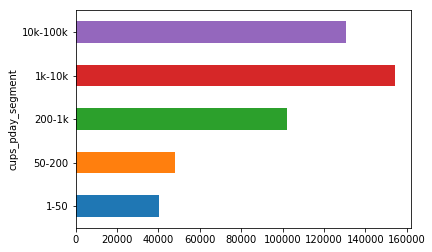

In [24]:
## We create bins of # of cups

destinations_sum['cups_pday_segment'] = pd.cut(destinations_sum.Count,include_lowest=True,
                                 bins=[1, 50, 200, 1000, 10000, 100000], 
                                 labels=['1-50','50-200','200-1k', '1k-10k', '10k-100k']).dropna()

## We aggregate to see how the bins distribute
destinations_sum_grouped = destinations_sum.reset_index().groupby(['cups_pday_segment']).size().rename('Destinations').to_frame()\
.join(
    destinations_sum.reset_index().groupby(['cups_pday_segment']).sum()[["cups_pday"]]
)

destinations_sum_grouped.Destinations.plot.barh()
destinations_sum_grouped.cups_pday.plot.barh()

destinations_sum_grouped.head()

## We write the output of cups distribution for visualization

In [28]:
destinations_sum.to_csv("cups_per_day.tsv",sep="\t")

In [29]:
#destinations_sum.loc['3145']#.reset_index().groupby(['PLZ Name'])

## Addendum: Other data sets

 - shops with coffee selling points
 - number of train stations
 

In [38]:
geschaefte = pd.read_csv('./offnungszeiten-shops.csv',sep=';')
cafes = pd.read_csv('./MappingCafes.utf.csv',sep=';',header=None,names=['cafe','bool']).query('bool==1')
geschaefte = geschaefte.loc[geschaefte.Geschäft.isin(cafes.cafe.values)]
geschaefte.head()
#geschaefte.Geschäft.value_counts()

,location,didok,Geschäft,Kategorie,Ebene,Bahnhof,offen,URL,Email,tel,Beschreibung,PaymentAccepted,geo
0,https://lod.opentransportdata.swiss/place/8503...,http://lod.opentransportdata.swiss/didok/8503125,K Kiosk,Kioske / Tabakwaren,Stadtebene,Uster,So 07:00-22:00,http://www.kkiosk.ch/,NaN,NaN,Gönn dir was!\nk kiosk ist der persönliche Gar...,NaN,POINT(8.718343772603966 47.35050747087967)
7,https://lod.opentransportdata.swiss/place/8503...,http://lod.opentransportdata.swiss/didok/8503125,K Kiosk,Kioske / Tabakwaren,Stadtebene,Uster,Mo-Fr 05:45-20:00,http://www.kkiosk.ch/,NaN,NaN,Gönn dir was!\nk kiosk ist der persönliche Gar...,NaN,POINT(8.71682276650945 47.351377919345325)
12,https://lod.opentransportdata.swiss/place/8503...,http://lod.opentransportdata.swiss/didok/8503424,K Kiosk,Kioske / Tabakwaren,Stadtebene,Schaffhausen,Sa 06:00-22:00,http://www.kkiosk.ch/,NaN,+41 52 625 06 81,Gönn dir was!\nk kiosk ist der persönliche Gar...,NaN,POINT(8.63266133823397 47.698118687940955)
25,https://lod.opentransportdata.swiss/place/8503...,http://lod.opentransportdata.swiss/didok/8503504,K Kiosk,Kioske / Tabakwaren,Gleisebene,Baden,So 07:00-22:00,http://www.kkiosk.ch/,NaN,+41 56 222 44 23,Gönn dir was!\nk kiosk ist der persönliche Gar...,NaN,POINT(8.307773889422483 47.476287168518695)
26,https://lod.opentransportdata.swiss/place/8503...,http://lod.opentransportdata.swiss/didok/8503504,K Kiosk,Kioske / Tabakwaren,Gleisebene,Baden,Fr-Sa 05:00-00:00,http://www.kkiosk.ch/,NaN,+41 56 222 44 23,Gönn dir was!\nk kiosk ist der persönliche Gar...,NaN,POINT(8.307773889422483 47.476287168518695)


In [39]:
geschafte_count = geschaefte.groupby('Bahnhof').size().rename('Anzahl').reset_index()
geschafte_count

,Bahnhof,Anzahl
0,Aarau,4
1,Baden,3
2,Basel SBB,7
3,Bellinzona,2
4,Bern,20
5,Brig,4
6,Chur,4
7,Delémont,3
8,Fribourg/Freiburg,2
9,Genève,9


In [40]:
destinations_sum.reset_index().merge(geschafte_count,left_on='PLZ Name',right_on='Bahnhof')#.query('cup=="100-1k"')

,PLZ To,PLZ Name,Count,percent,cups_pday,cups_pday_segment,Bahnhof,Anzahl
0,1000,Lausanne,15.714286,0.000090,43,1-50,Lausanne,3
1,1003,Lausanne,533.571429,0.003042,1445,200-1k,Lausanne,3
2,1004,Lausanne,207.500000,0.001183,562,200-1k,Lausanne,3
3,1005,Lausanne,178.857143,0.001020,484,50-200,Lausanne,3
4,1006,Lausanne,380.142857,0.002167,1029,200-1k,Lausanne,3
5,1007,Lausanne,192.857143,0.001099,522,50-200,Lausanne,3
6,1010,Lausanne,55.071429,0.000314,149,50-200,Lausanne,3
7,1011,Lausanne,7.500000,0.000043,20,1-50,Lausanne,3
8,1012,Lausanne,68.071429,0.000388,184,50-200,Lausanne,3
9,1015,Lausanne,38.571429,0.000220,104,1-50,Lausanne,3


In [41]:
bahnhoefe=pd.read_csv('/Users/mpschr/Downloads/kontaktadressen.csv',sep=";")
#oeff.stationsbezeichnung


In [42]:
bahnhoefe=bahnhoefe[['PLZ','Ort','stationsbezeichnung']].drop_duplicates().dropna()\
        .assign(PLZ=lambda df: df.PLZ.fillna(0).astype('int').astype(str))
bahnhoefe

,PLZ,Ort,stationsbezeichnung
0,4410,Liestal,Liestal
1,4450,Sissach,Sissach
3,2735,Malleray-Bévilard,Malleray-Bévilard
4,2800,Delémont,Delémont
6,4143,Dornach-Arlesheim,Dornach-Arlesheim
7,2540,Grenchen,Grenchen Süd
9,4500,Solothurn,Solothurn
11,4702,Oensingen,Oensingen
12,4600,Olten,Olten
16,5070,Frick,Frick


In [43]:
bahnhoefe

,PLZ,Ort,stationsbezeichnung
0,4410,Liestal,Liestal
1,4450,Sissach,Sissach
3,2735,Malleray-Bévilard,Malleray-Bévilard
4,2800,Delémont,Delémont
6,4143,Dornach-Arlesheim,Dornach-Arlesheim
7,2540,Grenchen,Grenchen Süd
9,4500,Solothurn,Solothurn
11,4702,Oensingen,Oensingen
12,4600,Olten,Olten
16,5070,Frick,Frick


In [44]:
destinations_sum.reset_index().merge(bahnhoefe[['PLZ','Ort']], left_on='PLZ To', right_on='PLZ').cups_pday.sum()

153779